In [2]:
from sys import path
path.append('../')

import hsim.core.pymulate as pym
from hsim.core.chfsm import CHFSM, Transition, State
import pandas as pd
import numpy as np
from simpy import AnyOf
from copy import deepcopy
from random import choices,seed,normalvariate, expovariate
from hsim.core.stores import Store, Box       
from scipy import stats
import dill
import hsim.core.utils as utils
import time

c:\Users\Utente\GitHub\hsim\hsim\core\core.py:57: UserWarning: Bypassing "None" callbakcs
  warn('Bypassing "None" callbakcs')


In [15]:
# class Generator(pym.Generator):
#     def __init__(self,env,name=None,serviceTime=2,serviceTimeFunction=None):
#         super().__init__(env,name,serviceTime,serviceTimeFunction)
#         self.count = 0
#     def createEntity(self):
#         self.count += 1
#         # return Entity()
#         e = Entity()
#         # e.serviceTime = dict()
#         e.serviceTime['front'] = 10.52
#         e.serviceTime['drill'] = choices([3.5, 8.45, 9.65, 11.94],weights=[5,30,30,35])[0] ## Insert the possibility of skipping this stage
#         e.serviceTime['robot'] = choices([0, 81, 105, 108 ,120],weights=[91,3,2,2,2])[0]
#         # e.serviceTime['camera'] = choices([3,9,12,18,24],weights=[2,3,1,2,2])[0]
#         e.serviceTime['camera'] = 3.5+expovariate(1/7.1)
#         e.serviceTime['back'] = choices([3.5,10.57],weights=[0.1,0.9])[0]
#         # e.serviceTime['press'] = choices([3,9,15])[0]
#         if e.serviceTime['back']>0:
#             e.serviceTime['press'] = 3.5+expovariate(1/9.5)
#         else:
#             e.serviceTime['press'] = 3.5
#         e.serviceTime['manual'] = max(np.random.normal(9.2,1),0)
#         return e
        
class Entity:
    def __init__(self,ID=None):
        self.ID = ID
        self.rework = False
        self.serviceTime = dict()
        # self.pt['M3'] = 1
    @property
    def require_robot(self):
        if self.serviceTime['robot']>0:
            return True
        else:
            return False
    @property
    def ok(self):
        return not (self.rework and self.require_robot)
    def done(self):
        self.rework = False
                
class LabServer(pym.Server):
    def __init__(self,env,name=None,serviceTime=None,serviceTimeFunction=None):
        self.controller = None
        # serviceTime = 10
        super().__init__(env,name,serviceTime,serviceTimeFunction)
    def calculateServiceTime(self,entity=None,attribute='serviceTime'):
        if not entity.ok:
            return 3.5 ### qua andrà messo 10/20 volte maggiore degli altri processing time?
        else:
            return super().calculateServiceTime(entity,attribute)
    def completed(self):
        if self.var.entity.ok:
            self.controller.Messages.put(self.name)
    T2=Transition(pym.Server.Working, pym.Server.Blocking, lambda self: self.env.timeout(self.calculateServiceTime(self.var.entity)), action = lambda self: self.completed())
    T3=Transition(pym.Server.Blocking, pym.Server.Starving, lambda self: self.Next.put(self.var.entity),action=lambda self: [self.var.request.confirm(), self.sm.var.entity.done() if self.sm._name=='robot' else None])

class Terminator(pym.Terminator):
    def __init__(self, env, capacity=np.inf):
        super().__init__(env, capacity)
        self.controller = None
        self.register = list()
    def completed(self):
        if not self.trigger.triggered:
            self.trigger.succeed()
    def put(self,item):
        self.register.append(self._env.now)
        self.controller.Messages.put('terminator')
        return super().put(item)
    def subscribe(self,item):
        self.register.append(self._env.now)
        self.controller.Messages.put('terminator')
        return super().subscribe(item)
class Gate(CHFSM):
    def __init__(self,env):
        self.real = True
        self.capacity = 30
        self.lab = None
        self.initialWIP = 12
        self.targetWIP = 12
        self.request = None
        self.message = env.event()
        self.WIP = 0
        self.WIPlist = list()
        super().__init__(env)
    def build(self):
        self.Store = pym.Store(self.env,self.capacity)
        self.Messages = pym.Store(self.env)
    def put(self,item):
        return self.Store.put(item)
    class Loading(State):
        def _do(self):
            # print('Load: %d' %self.sm.initialWIP)
            self.sm.initialWIP -= 1
            self.fw()
    class Waiting(State):
        initial_state = True
        def _do(self):
            self.sm.message = self.Messages.subscribe()
            if self.sm.initialWIP > 0:
                self.initial_timeout = self.env.timeout(1)
            else:
                self.initial_timeout = self.env.event()
    class Forwarding(State):
        def _do(self):
            self.message.confirm()
            if self.message.value == 'terminator':
                self.sm.WIP -= 1
                self.sm.WIPlist.append([self.env.now,self.WIP])
            self.FIFO()
            self.CONWIP()
    def CONWIP(self):
        if self.message.value == 'terminator':
            self.fw()
    def FIFO(self):
        pass 
    def fw(self):        
        if self.request is None:
            #Scheduling Agent
            
            self.request = self.Store.get()
            # print(self.request)
            # print(type(self.request))
        try:
            self.Next.put(self.request.value)
            self.request = None
            self.WIP += 1
            self.WIPlist.append([self.env.now,self.WIP])
        except:
            pass
            # print('Empty at %s' %self.env.now)
    T0 = Transition(Waiting,Loading,lambda self: self.initial_timeout)
    T1 = Transition(Waiting,Forwarding,lambda self: self.sm.message)
    T2 = Transition(Loading,Waiting,None)
    T3 = Transition(Forwarding,Waiting,None)

class Router(pym.Router):
    def __deepcopy(self,memo):
        super().deepcopy(self,memo)
    def __init__(self, env, name=None):
        super().__init__(env, name)
        self.var.requestOut = []
        self.var.sent = []
        self.putEvent = env.event()
    def build(self):
        self.Queue = Box(self.env)
    def condition_check(self,item,target):
        return True
    def put(self,item):
        if self.putEvent.triggered:
            self.putEvent.restart()
        self.putEvent.succeed()
        return self.Queue.put(item)
    class Sending(State):
        initial_state = True
        def _do(self):
            self.sm.putEvent.restart()
            self.sm.var.requestIn = self.sm.putEvent
            self.sm.var.requestOut = [item for sublist in [[next.subscribe(item) for next in self.sm.Next if self.sm.condition_check(item,next)] for item in self.sm.Queue.items] for item in sublist]
            if self.sm.var.requestOut == []:
                self.sm.var.requestOut.append(self.sm.var.requestIn)
    S2S2 = Transition(Sending,Sending,lambda self:AnyOf(self.env,self.var.requestOut),condition=lambda self:self.var.requestOut != [])
    def action2(self):
        self.Queue._trigger_put(self.env.event())
        if not hasattr(self.var.requestOut[0],'item'):
            return
        for request in self.var.requestOut:
            if not request.item in self.Queue.items:
                request.cancel()
                continue
            if request.triggered:
                if request.check():
                    request.confirm()
                    self.Queue.forward(request.item)
                    continue
    S2S2._action = action2
'''  
from pymulate import RouterNew
class Router(RouterNew):
    def __init__(self, env, name=None):
        capacity=1
        super().__init__(env, name,capacity)
'''
class RobotSwitch1(Router):
    def condition_check(self, item, target):
        if item.require_robot:
            item.rework = True
        if item.require_robot and target.name == 'convRobot1S':
            return True
        elif not item.require_robot and target.name != 'convRobot1S':
            return True
        else:
            return False
            
class RobotSwitch2(Router):
    def condition_check(self, item, target):
        if len(target.Next)<2:
            item.rework = False
            return True
        else:
            item.rework = True
            return False    

class CloseOutSwitch(Router):
    def condition_check(self, item, target):
        if item.ok and type(target) == Terminator:
            return True
        elif not item.ok and type(target) != Terminator:
            return True
        else:
            return False
        
# class Conveyor(pym.ParallelServer):
#     def __init__(self,env,name=None,serviceTime=None,serviceTimeFunction=None,capacity=1):
#         self._capacity = capacity
#         serviceTime = capacity*3.5
#         super().__init__(env,name,serviceTime,serviceTimeFunction,capacity)
class Conveyor(pym.Conveyor):
    def __init__(self,env,name=None,capacity=3):
        super().__init__(env,name,capacity,0.75)
        
def newDT():
    lab = globals()['lab']
    deepcopy(lab)

def BN_detection(log,start,end):
    ' Step 1: Preparation of Raw Data'
      
    #LR
    log_file=pd.DataFrame(log)
    # log_file = log_file.loc[(log_file[4]>=start) & (log_file[4]<=end)]
    log_file = log_file.loc[(log_file[6]>=start) & (log_file[6]<=end)]
    # log_file[[4,5]].drop(inplace=True)
    log_file.drop(columns=[4,5],inplace=True)
    
    # log_file=log_file[[1,3,4,5]]
    log_file=log_file[[1,3,6,7]]
    log_file=log_file.loc[log_file[1].isin(['front','drill','robot','camera','back','press','manual'])]
    # log_file=log_file.rename(columns={1:'resource',3:'activity',4:'timeIn',5:'timeOut'})
    log_file=log_file.rename(columns={1:'resource',3:'activity',6:'timeIn',7:'timeOut'})
    log_file.loc[log_file.activity=='Working','activity']='Work'
    log_file.loc[log_file.activity=='Blocking','activity']='Block'
    log_file.loc[log_file.activity=='Starving','activity']='Starve'
    from datetime import datetime
    log_file['timeIn'] = pd.to_timedelta(log_file['timeIn'],'s')+datetime.now()
    log_file['timeOut'] = pd.to_timedelta(log_file['timeOut'],'s')+datetime.now()

    
    # Rewrite the log_file as Time|Process|Status
    data = pd.DataFrame(columns = ['Time','Process','Status'])
    data[['Time','Process','Status']] = log_file[['timeIn','resource','activity']]
    
    Tmax = log_file['timeOut'].max()
    data.Status.replace("Work",1,inplace=True)     
    data.Status.replace(["Starve","Block"],0,inplace=True)
    
    #LR
    # data=data.drop_duplicates(subset=['Time'],keep='last')
    # LR alt
    data = data.pivot_table(index='Time', columns='Process', values = 'Status')
    data = data.fillna(method='ffill')
    data.fillna(0, inplace=True)
    data=data.drop_duplicates(keep='last')

    
    # Transfrom Long table (Time|Process|Staus) into Short table (Time|M1|M2|...|)
    # data = data.pivot(index='Time', columns='Process', values = 'Status')
    
    # Fill enmpty entries with data from previous entries
    data = data.fillna(method='ffill')
    data.fillna(0, inplace=True)
    ' Step 2: Accumulation Transformation'
    
    # Entering actual duration of active states
    data_interval = data.copy(deep=True)
    # data_interval['Time'] = data_interval.index
    
    data_interval['Time'] = np.append(np.diff(data_interval.index.values)/np.timedelta64(1,'s'),(Tmax-data_interval.index[-1])/np.timedelta64(1,'s'))
    data_interval=data_interval.multiply(data_interval.Time,axis="index")
    
    # Cumulative duration
    data_interval=data_interval.cumsum()
    data_interval.drop(columns=['Time'],inplace=True)
         
    # Total duration of active periods
    for s in data_interval:
        data_interval[s][data_interval[s]>0] = data_interval[s].max()

    ' Step 3: Bottleneck detection'
    
    # Momentary BN detection

    for i in range(data_interval.shape[0]):
        for j in range(data_interval.shape[1]):
            if type(data_interval.iloc[i,j]) == pd._libs.tslibs.timedeltas.Timedelta:
               data_interval.iloc[i,j] = data_interval.iloc[i,j].total_seconds()
    
    data_interval.values[range(len(data_interval.index)), np.argmax(data_interval.values, axis=1)] = -1        
               
    # Backward check
    data_interval[np.multiply(data_interval.values*np.vstack([data_interval.values[1:,:],np.zeros([1,data_interval.shape[1]])])<0,data_interval.values>0)] = -1
               
    # Forward check 
    data_interval[np.multiply(data_interval.values*np.vstack([np.zeros([1,data_interval.shape[1]]),data_interval.values[:-1,:]])<0,data_interval.values>0)] = -1
    ' Step 4: Shfting Bottleneck detection'
    
    # Shifting BN 
    s=(data_interval[data_interval==-1].fillna(0).sum(axis=1)<-1)
    
    # LR edit:
    data_interval.loc[s[s].index] = data_interval.loc[s[s].index] * 2
    # data_interval.loc[s[s].index].replace(-1,-2,inplace=True)

    ' Step 5: Bottleneck percentages computation'
    
    
    data_interval['Time'] = np.append(np.diff(data_interval.index.values)/np.timedelta64(1,'s'),(Tmax-data_interval.index[-1])/np.timedelta64(1,'s'))
    # Sole BN duration
    BN_sole = data_interval.copy(deep=True)
    BN_sole.values[BN_sole.values>0]=0
    BN_sole.values[BN_sole.values==-2]=0
    BN_sole.values[BN_sole.values==-1]=1
    BN_sole['Time'] = np.append(np.diff(data_interval.index.values)/np.timedelta64(1,'s'),(Tmax-data_interval.index[-1])/np.timedelta64(1,'s'))
    BN_sole=BN_sole.multiply(BN_sole.Time,axis="index")
    BN_sole.drop(columns=['Time'],inplace=True)
    
    # Shifting BN duration
    BN_shifting = data_interval.copy(deep=True)
    BN_shifting.values[BN_shifting.values>=-1]=0
    BN_shifting.values[BN_shifting.values==-2]=1
    BN_shifting['Time'] = np.append(np.diff(data_interval.index.values)/np.timedelta64(1,'s'),(Tmax-data_interval.index[-1])/np.timedelta64(1,'s'))
    BN_shifting=BN_shifting.multiply(BN_shifting.Time,axis="index")
    BN_shifting.drop(columns=['Time'],inplace=True)

    col = []
    for i in range(1, BN_sole.shape[1]+1):
        col.append('M%s' %i)
    
    if BN_shifting.values.sum()>1:
        if BN_shifting.values.sum()/BN_sole.values.sum()>0.1:
            BNs=(BN_sole>0).astype(int)
            BNshift=(BN_shifting>0).astype(int).apply(lambda x: -x)
            BNn=BNs+BNshift
            BNn['start']=BNn.index.values
            BNn['end']=BNn.index.values[1:].tolist()+[0]
            BNn = BNn.drop(BNn.index[-1])
            melted_df = BNn.melt(id_vars=['start', 'end'], value_vars=['back', 'camera', 'drill', 'front', 'manual', 'press'],  var_name='resource', value_name='value')
            melted_df.value=melted_df.value.replace({-1:'Shifting BN',1:'Sole BN',0:None})
            import plotly.express as px
            try:
                fig=px.timeline(melted_df,x_start='start',x_end='end',y='resource',color='value')
                for i in range(100):
                    try:
                        with open('fig'+str(i)+'.pdf') as f:
                            pass
                    except:
                        fig.write_image('fig'+str(i)+'.pdf')
                        break
            except Exception as inst:
                print(inst)
    # BN_synthetic = pd.DataFrame(columns = col, index = ['Sole BN', 'Shifting BN', 'Tot BN'])
    BN_synthetic=pd.concat([BN_sole.sum(),BN_shifting.sum(),BN_sole.sum()+BN_shifting.sum()],axis=1).transpose()
    BN_synthetic.index=['Sole BN', 'Shifting BN', 'Tot BN']

    # Create bar chart
    BN_synthetic1 = BN_synthetic.copy(deep=True)
    BN_synthetic1 = BN_synthetic1.drop('Tot BN',axis=0)
    if BN_shifting.values.sum()>1:
        if BN_shifting.values.sum()/BN_sole.values.sum()>0.1:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 6))
            BN_synthetic1.transpose().plot(kind='bar', stacked=True)
            plt.xlabel('Resource')
            plt.ylabel('Time [seconds]')
            plt.title('BN analysis results')
            plt.legend(title='BN type')
            plt.grid(True)
            plt.savefig('figg'+str(i)+'.pdf', format="pdf", bbox_inches="tight",dpi=900)
    BN_synthetic1.reset_index(inplace=True)
    BN_synthetic1 = BN_synthetic1.melt(id_vars='index', var_name='Resource', value_name='Time percentage')
    BN_synthetic1.rename(columns ={ 'index' : 'BN type'}, inplace = True)

    #LR
    BN_synthetic=BN_synthetic.divide(BN_synthetic.sum(axis=1).values,axis=0).fillna(0)

    # BN finder
    BN_percentages = BN_synthetic.iloc[2,:]
    
    BN_string=[]
    maxval = np.max(BN_percentages.values)
    for i in range(len(BN_percentages.values)):
        if BN_percentages.values[i] == maxval:
            BN_string.append(BN_percentages.index[i])
        
    # [BN_synthetic, data_interval, BN_string] 
    # print(BN_string)
    # return BN_string
    

    maxval = np.max(BN_percentages.values)
    for i in range(len(BN_percentages.values)):
        if BN_percentages.values[i] == maxval:
            return BN_percentages.index[i],BN_percentages
'''
class Generator(Generator):
    def createEntity(self):
        self.count += 1
        if len(self.jList)==1: #last
            self.var.serviceTime = 10e100
        return self.jList.pop(0)
    def newEntity(self):
        self.count += 1
        # return Entity()
        e = Entity()
        # e.serviceTime = dict()
        e.serviceTime['front'] = 10.52
        e.serviceTime['drill'] = choices([3.5, 8.45, 9.65, 11.94],weights=[5,30,30,35])[0]
        e.serviceTime['robot'] = choices([0, 81, 105, 108 ,120],weights=[91,3,2,2,2])[0]
        # e.serviceTime['camera'] = choices([3,9,12,18,24],weights=[2,3,1,2,2])[0]
        e.serviceTime['camera'] = 3.5+expovariate(1/7.1)
        e.serviceTime['back'] = choices([3.5,10.57],weights=[0.1,0.9])[0]
        # e.serviceTime['press'] = choices([3,9,15])[0]
        if e.serviceTime['back']>0:
            e.serviceTime['press'] = 3.5+expovariate(1/9.5)
        else:
            e.serviceTime['press'] = 3.5
        e.serviceTime['manual'] = max(np.random.normal(9.2,1),0)
        return e
'''
# def newEntity():
#     seed(time.time())
#     e = Entity()
#     e.serviceTime['front'] = 10.52
#     e.serviceTime['drill'] = 40 #choices([30, 40, 50, 20],weights=[5,30,30,35])[0]
#     e.serviceTime['robot'] = choices([0, 81, 105, 108 ,120],weights=[91,3,2,2,2])[0]
#     e.serviceTime['camera'] = 3.5+expovariate(1/7.1)
#     e.serviceTime['back'] = choices([3.5,10.57],weights=[0.1,0.9])[0]
#     if e.serviceTime['back']>0:
#         e.serviceTime['press'] = 3.5+expovariate(1/9.5)
#     else:
#         e.serviceTime['press'] = 3.5
#     e.serviceTime['manual'] = max(np.random.normal(9.2,1),0)
#     return e

def newEntity():
    seed(time.time())
    e = Entity()
    e.serviceTime['front'] = 10.52
    e.serviceTime['drill'] = choices([30, 40, 50, 20],weights=[5,30,30,35])[0]
    e.serviceTime['robot'] = choices([0, 81, 105, 108 ,120],weights=[91,3,2,2,2])[0]
    e.serviceTime['camera'] = 3.5+expovariate(1/7.1)
    e.serviceTime['back'] = choices([3.5,10.57],weights=[0.1,0.9])[0]
    if e.serviceTime['back']>0:
        e.serviceTime['press'] = 3.5+expovariate(1/7.5)
    else:
        e.serviceTime['press'] = 3.5
    e.serviceTime['manual'] = max(np.random.normal(9.2,2),0)
    return e

def batchCreate(seed=1,numJobs=10):
    np.random.seed(seed)
    jList = []
    while len(jList)<numJobs:
        e=newEntity()
        jList.append(e)
    return jList

class Lab:
    def __init__(self):
        conveyTime = 6
        self.env = pym.Environment() #crea l'ambiente
        # self.g = Generator(self.env) #genera un nuovo pezzo
        self.gate = Gate(self.env) #da togliere ma ci sarà bisogno di modifiche #gestisce l'ingresso dei pezzi
        # DR= despaching rule OR=order release
        # self.conv1 = Conveyor(self.env,capacity=3)
        self.conv1S = pym.Server(self.env,serviceTime=conveyTime) 
        self.conv1Q = pym.Queue(self.env,capacity=2)
        self.front = LabServer(self.env,'front')
        # self.conv2 = Conveyor(self.env,capacity=3)
        self.conv2S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv2Q = pym.Queue(self.env,capacity=2)
        self.drill = LabServer(self.env,'drill')
        # self.conv3 = Conveyor(self.env,capacity=3)
        self.conv3S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv3Q = pym.Queue(self.env,capacity=2)

        
        self.switch1 = RobotSwitch1(self.env)
        # self.convRobot1 = Conveyor(self.env,'convRobot1',capacity=3)
        self.convRobot1S = pym.Server(self.env,serviceTime=conveyTime,name='convRobot1S')
        self.convRobot1Q = pym.Queue(self.env,capacity=2)

        # self.bridge = Conveyor(self.env,capacity=3)
        self.bridgeS = pym.Server(self.env,serviceTime=conveyTime)
        self.bridgeQ = pym.Queue(self.env,capacity=2)

        # self.convRobot2 = Conveyor(self.env,'convRobot2',capacity=3)
        self.convRobot2S = pym.Server(self.env,serviceTime=conveyTime)
        self.convRobot2Q = pym.Queue(self.env,capacity=2)

        self.switch2 = RobotSwitch2(self.env)
        # self.convRobot3 = Conveyor(self.env,capacity=3)
        self.convRobot3S = pym.Server(self.env,serviceTime=conveyTime)
        self.convRobot3Q = pym.Queue(self.env,capacity=2)

        self.robot = LabServer(self.env,'robot')
        # self.convRobotOut = Conveyor(self.env,capacity=3)
        self.convRobotOutS = pym.Server(self.env,serviceTime=conveyTime)
        self.convRobotOutQ = pym.Queue(self.env,capacity=2)
        # self.conv5 = Conveyor(self.env,capacity=3)
        self.conv5S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv5Q = pym.Queue(self.env,capacity=2)

        self.camera = LabServer(self.env,'camera')
        # self.conv6 = Conveyor(self.env,capacity=3)
        self.conv6S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv6Q = pym.Queue(self.env,capacity=2)

        self.back = LabServer(self.env,'back')
        # self.conv7 = Conveyor(self.env,capacity=3)
        self.conv7S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv7Q = pym.Queue(self.env,capacity=2)

        self.press = LabServer(self.env,'press')
        # self.conv8 = Conveyor(self.env,capacity=3)
        self.conv8S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv8Q = pym.Queue(self.env,capacity=2)

        self.manual = LabServer(self.env,'manual')
        self.outSwitch = CloseOutSwitch(self.env)
        self.terminator = Terminator(self.env)
        
        #self.g.Next = self.gate
        self.gate.Next = self.conv1S
        
        # self.conv1.Next = self.front
        self.conv1S.Next = self.conv1Q
        self.conv1Q.Next = self.front

        self.front.Next = self.conv2S
        # self.conv2.Next = self.drill
        self.conv2S.Next = self.conv2Q
        self.conv2Q.Next = self.drill
        self.drill.Next = self.conv3S
        self.conv3S.Next = self.conv3Q
        self.conv3Q.Next = self.switch1
        # self.conv3.Next = self.switch1
        
        self.switch1.Next = [self.convRobot1S,self.bridgeS]
        self.convRobot1S.Next = self.convRobot1Q
        self.convRobot1Q.Next = self.switch2

        self.switch2.Next = [self.convRobot2S,self.convRobot3S]
        self.convRobot2S.Next = self.convRobot2Q
        self.convRobot2Q.Next = self.robot

        self.convRobot3S.Next = self.convRobot3Q
        self.convRobot3Q.Next = self.convRobotOutS

        self.robot.Next = self.convRobotOutS
        self.convRobotOutS.Next = self.convRobotOutQ

        self.convRobotOutQ.Next = self.conv5S
        self.bridgeS.Next = self.bridgeQ
        self.bridgeQ.Next = self.conv5S

        
        self.conv5S.Next = self.conv5Q
        self.conv5Q.Next = self.camera

        self.camera.Next = self.conv6S
        self.conv6S.Next = self.conv6Q
        self.conv6Q.Next = self.back

        self.back.Next = self.conv7S
        self.conv7S.Next = self.conv7Q
        self.conv7Q.Next = self.press

        self.press.Next = self.conv8S
        self.conv8S.Next = self.conv8Q
        self.conv8Q.Next = self.manual

        self.manual.Next = self.outSwitch
        self.outSwitch.Next = [self.conv1S,self.terminator]
        
        for x in [self.front,self.drill,self.robot,self.camera,self.back,self.press,self.manual]:
            x.controller = self.gate
        self.terminator.controller = self.gate
        self.gate.lab = self

    def run(self,Tend):
        self.env.run(Tend)
        # return pd.DataFrame(self.env.state_log)
        return self.env.state_log





# import sys
# sys.path.insert(0,'C:/Users/Lorenzo/Dropbox (DIG)/Tesisti/Giovanni Zanardo/Python')
# from Foresighted_DT_function import BN_detection

# BN_detection(lab.env.state_log,0,lab.env.now)

class Result:
    def __init__(self,time,BN,OR,DR,production,arrivals,WIPlist,BNlist,state_log):
        self.time=time
        self.BN=BN
        self.OR=OR
        self.DR=DR
        self.production=production
        self.arrivals=arrivals
        self.WIPlist = WIPlist
        self.state_log=state_log
        self.BNlist = BNlist
    @property
    def avgWIP(self):
        integral = 0.0
        prev_time = None
        prev_value = None
        # Iterate over the data points and compute the integral
        for time, value in self.WIPlist:
            if prev_time is not None and prev_value is not None:
                dt = time - prev_time
                integral += prev_value * dt
            prev_time = time
            prev_value = value
        return integral/time
    @property
    def productivity(self):
        return (3600/pd.DataFrame(self.arrivals).diff()).describe()
    @property
    def CI(self):
        prod = self.productivity
        tinv = stats.t.ppf(1-0.05/2, prod[0][0])
        return prod[0][1] - prod[0][2]*tinv/np.sqrt(prod[0][0]), prod[0][1] + prod[0][2]*tinv/np.sqrt(prod[0][0])


In [4]:
lab=Lab()
lab.gate.Store.items = batchCreate(0,numJobs=30) #batchedExp
lab.run(3600)

df = pd.DataFrame(lab.env.state_log, columns=["Resource","ResourceName","State","StateName","Entity","?","timeIn","timeOut"])
df = df.loc[df.ResourceName.isin(["front","drill","robot","camera","back","press","manual"])]
fig = utils.createGantt(df)
fig.show()

makespan=df.timeOut.max()-df.timeIn.min()
print(makespan)

c:\Users\Utente\GitHub\hsim\hsim\core\utils.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.timeOut.fillna(df.timeOut.max(),inplace=True)


0 days 00:21:43.186514439


[497.38045313503335, 399.6602689976443, 592.7761363797453, 585.0070175059402, 306.3583019693735, 546.6797319677684, 499.67294724079863, 374.9942412410106, 541.9257911575118, 610.5681320281499, 846.1211086714934, 299.5363527439374, 318.74880626072985, 495.7372108644281, 293.5132867020958, 802.4973611761109, 600.7245387183839, 359.74172560278805, 291.7228235530781, 394.32365378361226, 594.3408665883096, 591.5711255884825, 761.9451627342264, 876.899023461548, 603.4416918032188, 506.0597141571961, 615.0303570632216, 285.23218132769955, 493.7503023431805, 289.8321961602203, 291.5640590579742, 714.5275076253675, 499.59226442172456, 475.42279853506545, 301.76849541879824, 282.13376628526424, 772.0231282269573, 289.60785694348994, 732.2066558113636, 336.2145267145829, 283.1152063869296, 342.4546787955985, 289.509691256848, 330.9623372763077, 737.0526999996687, 493.772536355039, 497.1309345577049, 390.26850764725725, 505.72274987713405, 598.3552785612256]


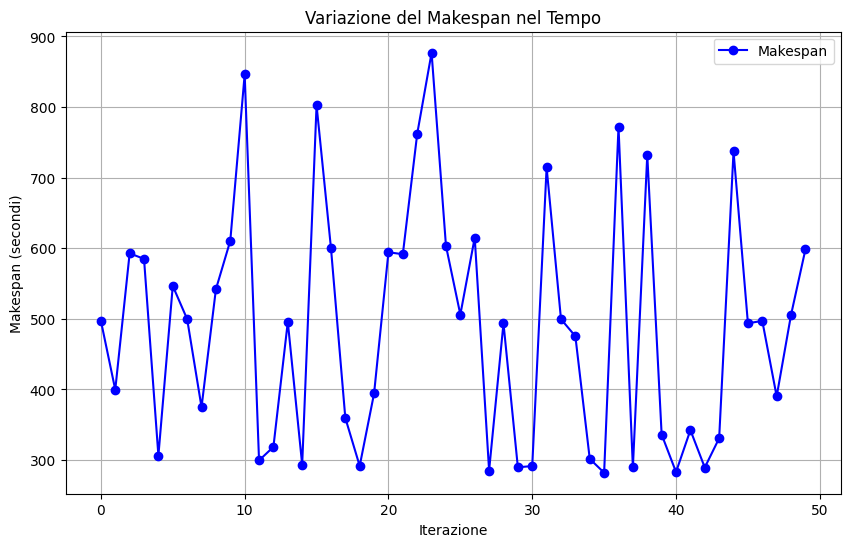

In [16]:
import matplotlib.pyplot as plt
makespan=[]
for i in range(50):
    lab = Lab()
    lab.gate.Store.items = batchCreate(0, numJobs=10)  # batchedExp serve per inizializzare 
    lab.run(3600)
    df = pd.DataFrame(lab.env.state_log, columns=["Resource","ResourceName","State","StateName","Entity","?","timeIn","timeOut"])
    df= df.loc[df.ResourceName.isin(["front","drill","robot","camera","back","press","manual"])]
    df.to_excel('dfnew.xlsx')
    mks=df.timeOut.max()-df.timeIn.min()
    makespan.append(mks)

print(makespan)
# Crea il grafico a linee
plt.figure(figsize=(10, 6))
plt.plot(makespan, marker='o', linestyle='-', color='b', label='Makespan')

# Aggiungi etichette e titolo
plt.xlabel('Iterazione')
plt.ylabel('Makespan (secondi)')
plt.title('Variazione del Makespan nel Tempo')
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()
    